In [1]:
import xarray as xr
import numpy as np
import os
import optuna
from glob import glob
import tqdm


import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter
import seaborn as sb
from cycler import cycler

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 'medium'
})

In [2]:
colors = {
    0.5: 'tab:blue',
    1.5: 'tab:red',
    2.5: 'tab:purple'
}

In [12]:
rerun = False

if not rerun:
    raise ValueError(
        '`rerun=False`. set `True` if you want to rerun (~12 min).'
    )

paths = glob(f'../logs/experiment_01/lightning_logs/version_*/predictions.nc')

iter_max = -1
path_max = -1
for p in tqdm.tqdm(paths):
    iter_len = len(xr.open_dataset(p).iter)
    if iter_len > iter_max:
        iter_max = iter_len
        path_max = p

ds_all = xr.open_dataset(path_max).q10
ds_all.values[:] = np.nan
ds_all = ds_all.expand_dims(
    {'q10_init': [0.5, 1.5, 2.5], 'dropout': [0.0, 0.2, 0.4, 0.6], 'rep': np.arange(10), 'use_ta': [0, 1]}).copy()

ds_counter = xr.open_dataset(paths[0]).q10.isel(iter=0).drop('iter').expand_dims(
    {'q10_init': [0.5, 1.5, 2.5], 'dropout': [0.0, 0.2, 0.4, 0.6], 'use_ta': [0, 1]}).astype('int').copy()
ds_counter.values[:] = 0

error_count = 0
for i, p in enumerate(tqdm.tqdm(paths)):

    try:
        ds = xr.open_dataset(p)
    except:
        error_count += 1
        continue

    q10_init = ds.attrs['q10_init']
    dropout = ds.attrs['dropout']
    use_ta = bool(ds.attrs['use_ta'])

    rep = ds_counter.sel(q10_init=q10_init, dropout=dropout, use_ta=int(use_ta))

    if rep == 10:
        continue

    ds_all.loc[
        dict(
            q10_init=q10_init,
            dropout=dropout,
            use_ta=int(use_ta),
            rep=rep)
    ][:len(ds.q10.values)] = ds.q10.values

    ds_counter.loc[dict(q10_init=q10_init, dropout=dropout, use_ta=int(use_ta))] += 1

    if (ds_counter == 1).all().item():
        break

ds_all.to_netcdf('../logs/experiment_01/lightning_logs/predictions_grid.nc')

100%|██████████| 653/653 [00:54<00:00, 11.90it/s]


In [3]:
ds_all = xr.open_dataset('../logs/experiment_01/lightning_logs/predictions_grid.nc').load()

In [4]:
ds = xr.open_dataset('/Net/Groups/BGI/people/bkraft/data/Synthetic4BookChap.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T00:15:00 ... 2011-12-31T23:45:00
Data variables:
    sw_pot   (time) float64 ...
    dsw_pot  (time) float64 ...
    ta       (time) float64 ...
    reco     (time) float64 ...
    rb       (time) float64 ...

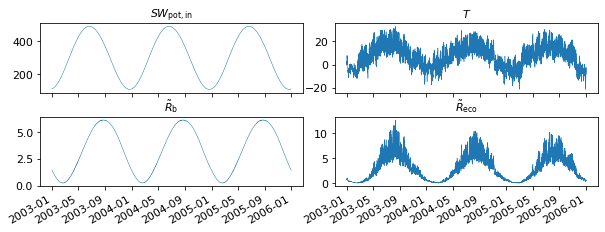

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 3), sharex=True, gridspec_kw={'hspace': 0.35, 'wspace': 0.12})

plot_kwargs = dict(
    lw=0.5
)

ds.sw_pot.sel(time=slice('2003', '2005')).plot(ax=axes[0, 0], **plot_kwargs)
ds.ta.sel(time=slice('2003', '2005')).plot(ax=axes[0, 1], **plot_kwargs)
ds.rb.sel(time=slice('2003', '2005')).plot(ax=axes[1, 0], **plot_kwargs)
ds.reco.sel(time=slice('2003', '2005')).plot(ax=axes[1, 1], **plot_kwargs)

axes[0, 0].set_title(r'$\tilde{R}_b$')


for ax, title in zip(
        axes.flat,
        [r'$SW_\mathrm{pot, in}$', r'$T$', r'$\tilde{R}_\mathrm{b}$', r'$\tilde{R}_\mathrm{eco}$']):

    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.savefig(f'./plots/data.png', dpi=300, transparent=True, bbox_inches='tight')

In [6]:
df_all = ds_all.to_dataframe().reset_index()

In [17]:
def plot_grid(df, with_temp, transparent=False):
    plt.rcParams.update({
        'axes.titley': 0.8
    })
    #df = df[df['iter']==0]
    g = sb.relplot(
        x='iter', y='q10', col='dropout', row='use_ta', hue='q10_init', style='rep',
        data=df, kind='line', dashes=False, height=1.8, aspect=0.8, palette='colorblind', alpha=0.5)

    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i, j]
            ax.axhline(1.5, ls=':', color='k', lw=1.4)

            if (i == 1) and (j == 0):
                ax.set_ylabel(r'$Q_{10}$ (with $T$)')
            else:
                ax.set_ylabel(r'$Q_{10}$ (without $T$)')

            if (i == 2) and (j == 1):
                ax.set_xlabel('Training iteration')
            else:
                ax.set_xlabel('')

            if i == 0:
                ax.set_title(ax.get_title().split(' | ')[1], y=1)
            else:
                ax.set_title('')

            if transparent:
                ax.patch.set_facecolor('none')

    g.legend.remove()

    h, l = g.axes[0, 0].get_legend_handles_labels()

    leg = g.axes[1, 1].legend(
        [Line2D([0], [0], color='k', ls=':', lw=1)] + h[1:4],
        [r'$Q_{10}$ true'] + l[1:4],
        frameon=False,
        ncol=4,
        title=r'$Q_{10}$ init:',
        loc='upper center',
        bbox_to_anchor=(1.1, -0.2))

    def legend_title_left(leg):
        c = leg.get_children()[0]
        title = c.get_children()[0]
        hpack = c.get_children()[1]
        c._children = [hpack]
        hpack._children = [title] + hpack.get_children()

    legend_title_left(leg)

    if not transparent:
        kwargs = dict(
            transparent=False,
            facecolor='w'
        )
    else: 
        kwargs = dict()

    g.axes[0, 0].set_xlim(None, 10000)

    g.savefig(f'./plots/q10_training.png', dpi=300, **kwargs)

    return g

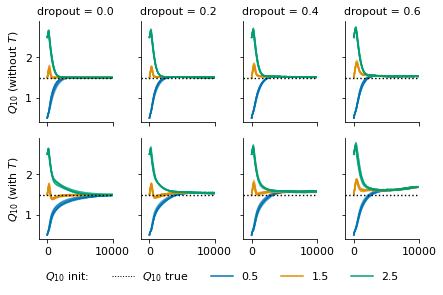

In [18]:
g = plot_grid(df_all, False, transparent=True)

In [9]:
1

1

In [20]:
study = optuna.study.load_study(study_name='q10hybrid', storage='sqlite:////Net/Groups/BGI/people/bkraft/git/q10hybrid/logs/experiment_01/optuna.db')
df = study.trials_dataframe()[[
    'value',
    'params_q10_init',
    'params_dropout',
    'params_use_ta',
    'user_attrs_q10']]

In [21]:
df = df.rename(columns={
    'value': 'loss',
    'params_q10_init': 'Q10 init',
    'params_dropout': 'dropout',
    'user_attrs_q10': 'Q10',
    'params_use_ta': 'With temperature'
})
df

,loss,Q10 init,dropout,With temperature,Q10
0,0.001446,1.5,0.2,False,1.500518
1,0.001446,1.5,0.2,False,1.500518
2,0.001496,2.5,0.2,True,1.531655
3,0.001993,2.5,0.4,False,1.514457
4,0.004539,0.5,0.6,True,1.689447
...,...,...,...,...,...
665,NaN,0.5,0.0,False,NaN
666,NaN,0.5,0.0,False,NaN
667,NaN,0.5,0.0,False,NaN
668,NaN,0.5,0.0,False,NaN


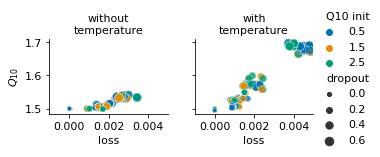

In [31]:
transparent = True

plt.rcParams.update({
    'axes.titley': 1.,
    'axes.titlelocation': 'center'
})

g = sb.relplot(x='loss', y='Q10', hue='Q10 init', size='dropout', col='With temperature', data=df, palette='colorblind', alpha=0.8, height=1.8, aspect=1.2)

#x = np.linspace(0.005, 0.07, 100)

#g.axes[0, 1].plot(x, np.sqrt(x)*10.1)
#g.axes[0, 1].plot(x, np.sqrt(x)*1.6)

#ax = g.axes[0, 1]
#ax.plot(x, np.sqrt(x) * 2 + 1.1, color='k', alpha=0.5, ls='--')
#ax.plot(x, np.sqrt(x) * 3 + 1.5, color='k', alpha=0.5, ls='--')

#ax.text(0.98, 0.26, f'weight decay = 0.0',
#    horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
#ax.text(0.98, 0.68, f'weight decay = 0.01',
#    horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
#ax.text(0.05, 0.9, f'weight decay = 0.1',
#    horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

#g.axes[0, 0].axhline(1.5, ls=':', color='k', lw=1.4)
#g.axes[0, 1].axhline(1.5, ls=':', color='k', lw=1.4)

g.axes[0, 0].set_ylabel(r'$Q_{10}$')

g.axes[0, 0].set_title('without\ntemperature')
g.axes[0, 1].set_title('with\ntemperature')

if transparent:
    for ax in g.axes.flatten():
        ax.patch.set_facecolor('none')
    kwargs = dict()
else:
    kwargs = dict(
        transparent=False,
        facecolor='w'
    )

g.axes[0, 0].set_xlim(-0.001, 0.005)
g.savefig(f'./plots/q10_interactions.png', dpi=300, **kwargs)

In [3]:
import time

In [4]:
tic = time.time()

In [5]:
toc = time.time() - tic

In [36]:
toc = 0 * 3600 + 2 * 60 + 7.9

In [37]:
hours = toc // 3600
toc = toc % 3600
minutes = toc / 60
toc = toc % 60
seconds = toc

In [38]:
print(f'Elapsed: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s')

Elapsed: 0h 2m 8s


In [39]:
import torch

In [42]:
torch.cuda.device_count()

8

In [41]:
torch.cuda.device(0)